# SVMs

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import utils6

# Linear Kernel

In [2]:
# load first dataset
data = loadmat('ex6data1.mat')

X, y = data['X'], data['y'][:,0]

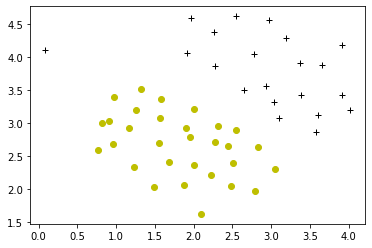

In [3]:
# plot data
plt.plot(X[y==0, 0], X[y==0, 1], 'yo')
plt.plot(X[y==1, 0], X[y==1, 1], 'k+')

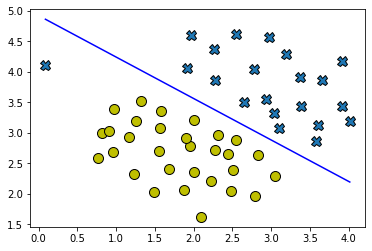

In [4]:
C = 1

model = utils6.svmTrain(X, y, C, utils6.linearKernel, 1e-3, 20)
utils6.visualizeBoundaryLinear(X, y, model)

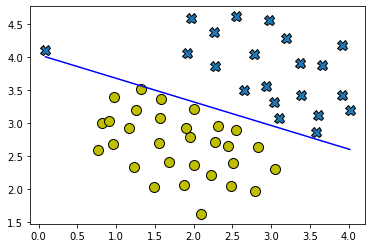

In [5]:
C = 100

model = utils6.svmTrain(X, y, C, utils6.linearKernel, 1e-3, 20)
utils6.visualizeBoundaryLinear(X, y, model)

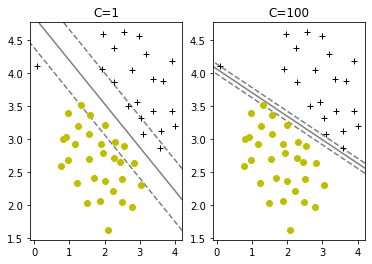

In [6]:
# compare to sklearn

# fit models
model1 = svm.SVC(C=1, kernel='linear').fit(X, y)
model100 = svm.SVC(C=100, kernel='linear').fit(X, y)

# plot data
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(X[y==0, 0], X[y==0, 1], 'yo')
ax1.plot(X[y==1, 0], X[y==1, 1], 'k+')
ax1.set_title("C=1")

ax2.plot(X[y==0, 0], X[y==0, 1], 'yo')
ax2.plot(X[y==1, 0], X[y==1, 1], 'k+')
ax2.set_title("C=100")

# create test values from axis range
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# generate predicted values
Z1 = model1.decision_function(xy).reshape(XX.shape)
Z100 = model100.decision_function(xy).reshape(XX.shape)

# add to plots
ax1.contour(XX, YY, Z1, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
ax2.contour(XX, YY, Z100, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Gaussian Kernel

In [7]:
# create Gaussian kernel function to get a sense of the math - we'll use the built-in 'rbf' kernel in sklearn for the actual SVMs
def gaussianKernel(x1, x2, sigma):
    return np.exp(-np.sum((x1 - x2)**2) / (2 * (sigma**2)))

In [8]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2 

sim = gaussianKernel(x1, x2, sigma)

print('Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = %0.2f:'
      '\n\t%f\n(for sigma = 2, this value should be about 0.324652)\n' % (sigma, sim))

Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = 2.00:
	0.324652
(for sigma = 2, this value should be about 0.324652)



In [9]:
# load second dataset
data = loadmat('ex6data2.mat')

X, y = data['X'], data['y'][:, 0]

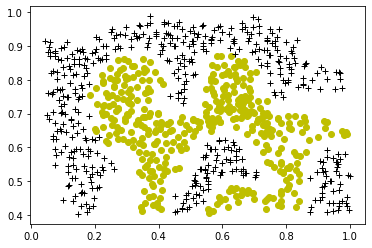

In [10]:
# plot data
plt.plot(X[y==0, 0], X[y==0, 1], 'yo')
plt.plot(X[y==1, 0], X[y==1, 1], 'k+')

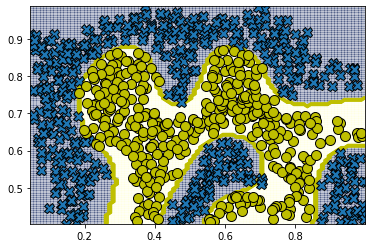

In [11]:
# SVM Parameters
C = 1
sigma = 0.1

model= utils6.svmTrain(X, y, C, gaussianKernel, args=(sigma,))
utils6.visualizeBoundary(X, y, model)

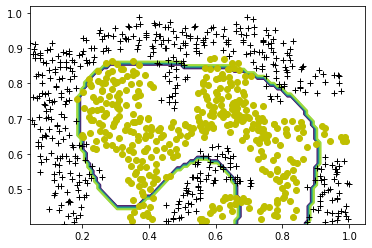

In [12]:
# compare to sklearn

# fit model
model = svm.SVC(C=1, kernel='rbf').fit(X, y)

# plot curve
plt.plot(X[y==0, 0], X[y==0, 1], 'yo')
plt.plot(X[y==1, 0], X[y==1, 1], 'k+')

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, linewidths=2)

Interesting that the canned SVM from scikit-learn has more in-sample bias than the from-scratch algorithm supplied by Ng. The 'gamma' parameter in sklearn seems to do something different from the 'sigma' parameter in the custom SVC function. The sklearn function is much faster.

# Automating Parameter Selection

In [14]:
# load new dataset
data = loadmat('ex6data3.mat')

X, y, Xval, yval = data['X'], data['y'][:, 0], data['Xval'], data['yval'][:, 0]

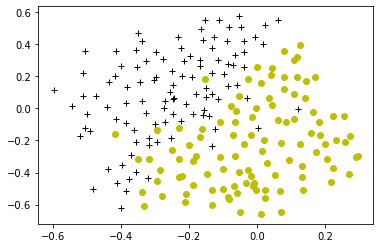

In [15]:
# plot
plt.plot(X[y==0, 0], X[y==0, 1], 'yo')
plt.plot(X[y==1, 0], X[y==1, 1], 'k+')

In [18]:
# create function to choose optimal C and sigma
def dataset3Params(X, y, Xval, yval):
    # initialize
    C = 1
    sigma = 0.3
    
    # candidate values
    C_array = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])
    sigma_array = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])
    err_array = np.zeros([C_array.size, sigma_array.size])
    
    for i in np.arange(C_array.size):
        for j in np.arange(sigma_array.size):
            model = utils6.svmTrain(X, y, C_array[i], gaussianKernel, args=(sigma_array[j],))
            predictions = utils6.svmPredict(model, Xval)
            pred_error = np.mean(predictions != yval)
            
            err_array[i, j] = pred_error
            
    ind = np.unravel_index(np.argmin(err_array, axis = None), err_array.shape)
    C = C_array[ind[0]]
    sigma = sigma_array[ind[1]]
    
    return C, sigma

1.0 0.1


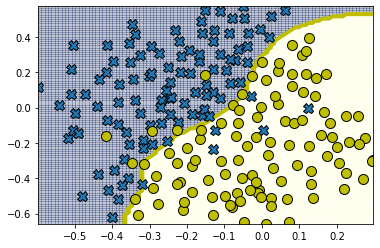

In [19]:
# apply function
C, sigma = dataset3Params(X, y, Xval, yval)

# train model
model = utils6.svmTrain(X, y, C, gaussianKernel, args=(sigma,))
utils6.visualizeBoundary(X, y, model)
print(C, sigma)